In [50]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from datetime import date
from datetime import timedelta  
sns.set_context('notebook')

# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [2]:
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

In [3]:
DATA_FOLDER = './Data' 
EBOLA_FOLDER = DATA_FOLDER + '/ebola'

GUINEA_FOLDER = EBOLA_FOLDER + '/guinea_data'
LIBERIA_FOLDER = EBOLA_FOLDER + '/liberia_data'
SIERRA_LEONE_FOLDER = EBOLA_FOLDER + '/sl_data'

## Task 1. Compiling Ebola Data

<p>
    <div class="lev1">
        <a href="#1---Cleaning-Guinea">1 - Cleaning Guinea</a>
    </div>
    <div class="lev2">
        <a href="#2---Cleaning-Liberia">2 - Cleaning Liberia</a>
    </div>
    <div class="lev3">
        <a href="#3---Cleaning-Sierra-Leone">3 - Cleaning Sierra Leone</a>
    </div>
 </p>

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### 1 - Cleaning Guinea

We want to identify the models. We will call model the different kind of ```Description``` values that are present in files. To be able to clean them as a whole. We will drop the columns of each region as we are only interested in national numbers. 

We use ```glob``` in order to get all UNIX style pathname pattern expansion to be able to import all files.

In [4]:
def find_model(distinct_model_variables,current_model):
    for i,d in enumerate(distinct_model_variables):
        if d == current_model:
            return i
    return -1

def print_distinct_model_repartition(n_distinct_models, belongs_to):
    for model_num in range(0,n_distinct_models):
        n_model = len([x for x in belongs_to if x == model_num])
        print("{} file(s) in model {}".format(n_model,model_num))

def get_distinct_model(path_to_folder,desc_col_name,date_col_name,total_col_name):
    country_df = pd.DataFrame()
    list_ = []
    distinct_model_variables = []
    belongs_to_model = []
    
    allFiles = glob.glob(path_to_folder + "/*.csv")
    cols_to_use = [desc_col_name,date_col_name,total_col_name]
    

    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0,usecols=cols_to_use,parse_dates=[date_col_name],thousands=',')
        list_.append(df)
    
    for df in list_:
        current_model = set(df[desc_col_name].values)
        index = find_model(distinct_model_variables,current_model)
        if(index == -1):
            distinct_model_variables.append(current_model)
            belongs_to_model.append(len(distinct_model_variables)-1)
        else:
            belongs_to_model.append(index)
    
    n_distinct_models = len(distinct_model_variables)
    print('We have found {} different model(s).'.format(n_distinct_models))
    print_distinct_model_repartition(n_distinct_models,belongs_to_model)
    
    return (list_,distinct_model_variables,belongs_to_model)

def get_grouped_dataframes(path_to_folder,desc_col_name,date_col_name,total_col_name):
    (dfs,distinct_model_variables,belongs_to_model) = get_distinct_model(path_to_folder,desc_col_name,date_col_name,total_col_name)
    
    n_distinct_models = len(distinct_model_variables)
    model_dataframes = []
    for i in range(0,n_distinct_models):
        list_ = []

        for j,m in enumerate(belongs_to_model):
            if(m == i):
                list_.append(dfs[j])
        
        # We also parse the date and get rid of the 'Date' column
        df = pd.concat(list_)
        df['Month'] = df[date_col_name].map(lambda x:x.month)
        df['Day'] = df[date_col_name].map(lambda x:x.day)
        df = df.drop(date_col_name,axis=1)
        
        df.set_index(['Month','Day',desc_col_name],inplace=True)
        #df = df.dropna()
        
        if df.index.is_unique:
            df = df[[total_col_name]].unstack(desc_col_name)
            
            # To avoid hierarchical columns, we drop the first level
            df.columns = df.columns.droplevel(0)
            df.columns.name = ''

        model_dataframes.append(df)
    return model_dataframes

In [5]:
path = GUINEA_FOLDER
model_dataframes = get_grouped_dataframes(GUINEA_FOLDER,'Description','Date','Totals')
df_model_0 = model_dataframes[0]

We have found 2 different model(s).
1 file(s) in model 0
21 file(s) in model 1


We have found 2 different 'models' of description values. Therefore we select the columns of interest for each of them. To do so we list the columns and look at those that talk about cases and deaths.

In [6]:
# We check for deaths
cols = df_model_0.columns.values.tolist()
rel_cols = [c for c in cols if 'deaths' in c]

In [7]:
df_model_0.loc[:,rel_cols]

,,New deaths registered today,New deaths registered today (confirmed),New deaths registered today (probables),New deaths registered today (suspects),Number of deaths of confirmed cases among health workers,Number of deaths of probables cases among health workers,Total deaths (confirmed + probables + suspects),Total deaths of confirmed,Total deaths of probables,Total deaths of suspects,Total of deaths in confirmed cases in CTE
Month,Day,,,,,,,,,,,
8,4,2,2,0,0,12,8,363,228,133,2,138


We will only consider the column containing new, as the ```Total``` and ```Number``` columns seem to be cumulative. Seeing, that ```New deaths registered today = 2``` and that it equals the sum of :
* New deaths registered today (confirmed)
* New deaths registered today (probables) 
* New deaths registered today (suspects)

In [8]:
df_model_0['New Deaths'] = df_model_0[['New deaths registered today']]

In [9]:
# We check for cases
cols = df_model_0.columns.values.tolist()
rel_cols = [c for c in cols if ('cases' in c and ('new' in c or 'New' in c))]
df_model_0.loc[:,rel_cols]

,,New cases of confirmed,New cases of probables,New cases of suspects,Total new cases registered so far
Month,Day,,,,
8,4,4,0,5,9


Again we only keep the headers that contain both ``new`` (with or without caps) and ```cases```. One can see that the sum of all new cases (```confirmed+probables+suspects```) is in ```Total new cases registered so far```

In [10]:
df_model_0['New Cases'] =  df_model_0['Total new cases registered so far']

In [11]:
df_model_0 = df_model_0[['New Deaths','New Cases']]
model_dataframes[0] = df_model_0
df_model_0.head()

,,New Deaths,New Cases
Month,Day,,
8,4,2,9


Now we do the same pipeline for the second model

In [12]:
df_model_1 = model_dataframes[1]
# We check for deaths
cols = df_model_1.columns.values.tolist()
rel_cols = [c for c in cols if 'deaths' in c]
df_model_1.loc[:,rel_cols].head()

New deaths registered New deaths registered among health workers  \
Month Day                                                                    
8     26                      5                                          0   
      27                      2                                          0   
      30                      5                                          0   
      31                      3                                          0   
9     2                       5                                          0   

          Total deaths (confirmed + probables + suspects)  \
Month Day                                                   
8     26                                              958   
      27                                              438   
      30                                              468   
      31                                              489   
9     2                                               501   

          Total deaths of confirmed Total deaths of probables  \
Month Day                                                       
8     26                        292                       141   
      27                        294                       142   
      30                        324                       142   
      31                        337                       150   
9     2                         349                       150   

          Total deaths of suspects  \
Month Day                            
8     26                         2   
      27                         2   
      30                         2   
      31                         2   
9     2                          2   

          Total deaths registered among health workers  
Month Day                                               
8     26                                            26  
      27                                            26  
      30                                            26  
      31                                            26  
9     2                                             26

Again it seems like :
* ```New deaths registered among health workers``` is a particular case of the new deaths registerd and is therefore already included in there.
* ```Total ...``` seem to be stricly increasing (appart for some weird outliers on the 26 of july for total deaths) and must therefore be cumulative.
* ``` New deaths registered ``` is the only column that interests us

In [13]:
df_model_1['New Deaths'] = df_model_1[['New deaths registered']]

In [14]:
# We check for cases
cols = df_model_1.columns.values.tolist()
rel_cols = [c for c in cols if ('cases' in c )]
df_model_1.loc[:,rel_cols].head()

New cases of confirmed New cases of confirmed among health workers  \
Month Day                                                                      
8     26                      10                                           0   
      27                      10                                           0   
      30                       9                                           0   
      31                      29                                           0   
9     2                       14                                           0   

          New cases of probables New cases of suspects  \
Month Day                                                
8     26                     NaN                    18   
      27                       0                    12   
      30                       0                    15   
      31                       8                     9   
9     2                        0                    11   

          Total cases of confirmed Total cases of probables  \
Month Day                                                     
8     26                       490                      141   
      27                       499                      142   
      30                       533                      142   
      31                       563                      150   
9     2                        591                      150   

          Total cases of suspects Total new cases registered so far  \
Month Day                                                             
8     26                       30                                28   
      27                       22                                22   
      30                       32                                24   
      31                       36                                46   
9     2                        49                                25   

          Total number of hospitalized cases in CTE  \
Month Day                                             
8     26                                         87   
      27                                         80   
      30                                         82   
      31                                         99   
9     2                                         105   

          Total suspected non-class cases  
Month Day                                  
8     26                              518  
      27                              518  
      30                              560  
      31                              642  
9     2                               642

Here we can make the same usual observation, the only column of interest seems to be ```Total new cases registered so far``` is equal to the sum ```conmfirmed, supsects and probables```. The rest are cumulative values.

In [15]:
df_model_1['New Cases'] = df_model_1[['Total new cases registered so far']]

In [16]:
df_model_1 = df_model_1[['New Deaths','New Cases']]
model_dataframes[1] = df_model_1

Finally, we concatenate the two models to obtain a dataframe for the whole country. And compute the mean.

In [17]:
df_guinea = pd.concat(model_dataframes,axis=0)
df_guinea['Country'] = 'Guinea'
df_guinea['New Deaths'] = df_guinea['New Deaths'].astype(int)
df_guinea['New Cases'] = df_guinea['New Cases'].astype(int)
df_guinea = df_guinea.reset_index().groupby(['Country','Month']).mean()df_model_0 = model_dataframes[0]

# We check for deaths
cols = df_model_0.columns.values.tolist()
rel_cols = [c for c in cols if ('death' in c or 'Death' in c)]
df_model_0.loc[:,rel_cols].head()

By observing the data frame of our model, we see that the column that interest us is ```death_confirmed``` because we don't want to take into account deaths that were not caused for sure by Ebola. 

df = df_model_0.loc[:,['death_confirmed']]
df.head().round(3)
df_guinea.head()

New Deaths  New Cases
Country Month                       
Guinea  8           3.400     25.800
        9           3.562     19.625
        10         15.000     34.000

### 2 - Cleaning Liberia

In [18]:
path = LIBERIA_FOLDER
# by quickly opening the first few files we observed that columns that are going to be relevant for us
# are going to be Date, Variable and National columns. We assumed that the National columns was the correct number
# even though we saw some inconsistency between the different region sum and the total value supposed to be in the National Column
model_dataframes = get_grouped_dataframes(path,'Variable','Date','National')

We have found 6 different model(s).
55 file(s) in model 0
1 file(s) in model 1
11 file(s) in model 2
1 file(s) in model 3
8 file(s) in model 4
24 file(s) in model 5


Here again, we have found 5 different 'models' of description values. Therefore we select the columns of interest for each of them. To do so we list the columns and look at those that talk about cases and deaths.

#### model 0

In [19]:
df_model_0 = model_dataframes[0]

# We check for deaths
cols = df_model_0.columns.values.tolist()
rel_cols = [c for c in cols if 'deaths' in c]
print(rel_cols)

['Cumulative deaths among HCW', 'Newly Reported deaths in HCW', 'Newly reported deaths']


In [20]:
df_model_0.loc[:,rel_cols].head()

Cumulative deaths among HCW  Newly Reported deaths in HCW  \
Month Day                                                              
6     16                           1.0                           0.0   
      17                           1.0                           0.0   
      22                           1.0                           0.0   
      24                           2.0                           0.0   
      25                           3.0                           1.0   

           Newly reported deaths  
Month Day                         
6     16                     2.0  
      17                     0.0  
      22                     4.0  
      24                     4.0  
      25                     3.0

Here we will only consider the column ```Newly reported deaths``` because we are interested in the total number of death for each day and not the one among HCW.

In [21]:
df_model_0['New Deaths'] = df_model_0[['Newly reported deaths']]

# We check for deaths
cols = df_model_0.columns.values.tolist()
print(cols);
rel_cols = [c for c in cols if ('cases' in c or 'case' in c)]
df_model_0.loc[:,rel_cols].head()

['Case Fatality Rate (CFR) - Confirmed & Probable Cases', 'Contacts lost to follow-up', 'Contacts seen', 'Contacts who completed 21 day follow-up', 'Cumulative admission/isolation', 'Cumulative cases among HCW', 'Cumulative deaths among HCW', 'Currently under follow-up', 'New Case/s (Probable)', 'New Case/s (Suspected)', 'New admissions', 'New case/s (confirmed)', 'Newly Reported Cases in HCW', 'Newly Reported deaths in HCW', 'Newly reported contacts', 'Newly reported deaths', 'Specimens collected', 'Specimens pending for testing', 'Total Number of Confirmed Cases of Guinean Nationality', 'Total Number of Confirmed Cases of Sierra Leonean Nationality', 'Total confirmed cases', 'Total contacts listed', 'Total death/s in confirmed cases', 'Total death/s in confirmed, probable, suspected cases', 'Total death/s in probable cases', 'Total death/s in suspected cases', 'Total discharges', 'Total no. currently in Treatment Units', 'Total probable cases', 'Total specimens tested', 'Total suspec

Cumulative cases among HCW  New case/s (confirmed)  \
Month Day                                                       
6     16                          1.0                     1.0   
      17                          1.0                     0.0   
      22                          1.0                     5.0   
      24                          2.0                     4.0   
      25                          4.0                     2.0   

           Total confirmed cases  Total death/s in confirmed cases  \
Month Day                                                            
6     16                    12.0                               8.0   
      17                    12.0                               8.0   
      22                    28.0                              16.0   
      24                    33.0                              18.0   
      25                    35.0                              20.0   

           Total death/s in confirmed, probable, suspected cases  \
Month Day                                                          
6     16                                                16.0       
      17                                                16.0       
      22                                                25.0       
      24                                                32.0       
      25                                                37.0       

           Total death/s in probable cases  Total death/s in suspected cases  \
Month Day                                                                      
6     16                               6.0                               2.0   
      17                               6.0                               2.0   
      22                               8.0                               1.0   
      24                               8.0                               6.0   
      25                               8.0                               9.0   

           Total probable cases  Total suspected cases  
Month Day                                               
6     16                    6.0                    4.0  
      17                    6.0                    8.0  
      22                    8.0                    6.0  
      24                    8.0                   13.0  
      25                    9.0                   17.0

Here it seems that we should select the New case/s (confirmed) column as it seems to correspond to the daily new cases and is not cumulative.

In [22]:
# add the new cases to the model df
df_model_0['New Cases'] =  df_model_0['New case/s (confirmed)']
# return a df with only the New Death and New Cases
df_model_0 = df_model_0[['New Deaths','New Cases']]
model_dataframes[0] = df_model_0
df_model_0.head()

New Deaths  New Cases
Month Day                       
6     16          2.0        1.0
      17          0.0        0.0
      22          4.0        5.0
      24          4.0        4.0
      25          3.0        2.0

#### model 1

In [24]:
df_model_1 = model_dataframes[1]
df_model_1.head()

National
Month Day Variable                        
10    4   New Case/s (Suspected)      23.0
          New Case/s (Probable)       14.0
          New case/s (confirmed)       5.0
          Total suspected cases     1190.0
          Total probable cases      1796.0

In [25]:
print('df has unique index :', df_model_1.index.is_unique)
# here we observe that the model can't be unstack because the index is not unique 
#(several time the same Variable in the file)

# compute a list of the index appearing multiple times:
index_list = df_model_1.index.get_level_values(2).tolist()
multiple_index_list = [i for i in index_list if index_list.count(i)>1]

for index in multiple_index_list:
    print(df_model_1.query('Variable == @index'))

df has unique index : False
                                                         National
Month Day Variable                                               
10    4   Cumulative (confirmed + probable + suspected)    3921.0
          Cumulative (confirmed + probable + suspected)    3929.0
                                      National
Month Day Variable                            
10    4   Cumulative cases among HCW     190.0
          Cumulative cases among HCW     192.0
                                       National
Month Day Variable                             
10    4   Cumulative deaths among HCW      92.0
          Cumulative deaths among HCW      94.0
                                            National
Month Day Variable                                  
10    4   Total death/s in confirmed cases    1012.0
          Total death/s in confirmed cases    1018.0
                                           National
Month Day Variable                                 
10    4   To

We observe only a small difference between the value that are in double here, hence we choose to merge them and take the mean in order to be able to unstack the dataframe and see better what Variable we should choose for this particular model.

In [26]:
for index in multiple_index_list:
    # get the mean of the index values
    mean = df_model_1.query('Variable == @index').values.mean()
    # drop the multiple index from the df
    df_model_1.drop(index, level=2, inplace=True)
    # add the mean instead in the df
    df_model_1.loc[(df_model_1.index.get_level_values(0)[0], df_model_1.index.get_level_values(1)[0], index)] = [mean]


/anaconda/envs/ada/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/anaconda/envs/ada/lib/python3.6/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


In [27]:
# now our index should be unique:
print("my index are unique:", df_model_1.index.is_unique)

# so I can unstack and process like the other models:
df_model_1 = df_model_1[['National']].unstack('Variable')
            
# To avoid hierarchical columns, we drop the first level
df_model_1.columns = df_model_1.columns.droplevel(0)
df_model_1.columns.name = ''

df_model_1

my index are unique: True


,,Case Fatality Rate (CFR) - Confirmed & Probable Cases,Contacts lost to follow-up,Contacts seen,Contacts who completed 21 day follow-up,Cumulative (confirmed + probable + suspected),Cumulative CFR,Cumulative cases among HCW,Cumulative deaths among HCW,Currently under follow-up,New Case/s (Probable),...,Total confirmed cases,Total contacts listed,Total death/s in confirmed cases,"Total death/s in confirmed, probable, suspected cases",Total death/s in probable cases,Total death/s in suspected cases,Total discharges,Total no. currently in Treatment Units,Total probable cases,Total suspected cases
Month,Day,,,,,,,,,,,,,,,,,,,,,
10,4,62.7,2.0,3101.0,132.0,3925.0,62.8,191.0,93.0,6689.0,14.0,...,935.0,15271.0,1015.0,2204.5,700.0,489.5,25.0,448.0,1796.0,1190.0


In [28]:
# lets check for death:
cols = df_model_1.columns.values.tolist()
print(cols);
rel_cols = [c for c in cols if ('death' in c)]
df_model_1.loc[:,rel_cols].head()

['Case Fatality Rate (CFR) - Confirmed & Probable Cases', 'Contacts lost to follow-up', 'Contacts seen', 'Contacts who completed 21 day follow-up', 'Cumulative (confirmed + probable + suspected)', 'Cumulative CFR', 'Cumulative cases among HCW', 'Cumulative deaths among HCW', 'Currently under follow-up', 'New Case/s (Probable)', 'New Case/s (Suspected)', 'New admissions', 'New case/s (confirmed)', 'Newly Reported Cases in HCW', 'Newly Reported deaths in HCW', 'Newly reported contacts', 'Newly reported deaths', 'Total Case/s (Probable)', 'Total Case/s (Suspected)', 'Total Number of Confirmed Cases of Guinean Nationality', 'Total Number of Confirmed Cases of Sierra Leonean Nationality', 'Total case/s (confirmed)', 'Total confirmed cases', 'Total contacts listed', 'Total death/s in confirmed cases', 'Total death/s in confirmed, probable, suspected cases', 'Total death/s in probable cases', 'Total death/s in suspected cases', 'Total discharges', 'Total no. currently in Treatment Units', 'To

,,Cumulative deaths among HCW,Newly Reported deaths in HCW,Newly reported deaths,Total death/s in confirmed cases,"Total death/s in confirmed, probable, suspected cases",Total death/s in probable cases,Total death/s in suspected cases
Month,Day,,,,,,,
10,4,93.0,0.0,43.0,1015.0,2204.5,700.0,489.5


```Newly reported``` death seems to be the good columns to pick here for this model.

In [29]:
df_model_1['New Deaths'] = df_model_1[['Newly reported deaths']]

In [30]:
# now lets check for the new case of the day
cols = df_model_1.columns.values.tolist()
print(cols);
rel_cols = [c for c in cols if ('cases' in c or 'case' in c or 'Case' in c)]
df_model_1.loc[:,rel_cols].head()

['Case Fatality Rate (CFR) - Confirmed & Probable Cases', 'Contacts lost to follow-up', 'Contacts seen', 'Contacts who completed 21 day follow-up', 'Cumulative (confirmed + probable + suspected)', 'Cumulative CFR', 'Cumulative cases among HCW', 'Cumulative deaths among HCW', 'Currently under follow-up', 'New Case/s (Probable)', 'New Case/s (Suspected)', 'New admissions', 'New case/s (confirmed)', 'Newly Reported Cases in HCW', 'Newly Reported deaths in HCW', 'Newly reported contacts', 'Newly reported deaths', 'Total Case/s (Probable)', 'Total Case/s (Suspected)', 'Total Number of Confirmed Cases of Guinean Nationality', 'Total Number of Confirmed Cases of Sierra Leonean Nationality', 'Total case/s (confirmed)', 'Total confirmed cases', 'Total contacts listed', 'Total death/s in confirmed cases', 'Total death/s in confirmed, probable, suspected cases', 'Total death/s in probable cases', 'Total death/s in suspected cases', 'Total discharges', 'Total no. currently in Treatment Units', 'To

,,Case Fatality Rate (CFR) - Confirmed & Probable Cases,Cumulative cases among HCW,New Case/s (Probable),New Case/s (Suspected),New case/s (confirmed),Newly Reported Cases in HCW,Total Case/s (Probable),Total Case/s (Suspected),Total Number of Confirmed Cases of Guinean Nationality,Total Number of Confirmed Cases of Sierra Leonean Nationality,Total case/s (confirmed),Total confirmed cases,Total death/s in confirmed cases,"Total death/s in confirmed, probable, suspected cases",Total death/s in probable cases,Total death/s in suspected cases,Total probable cases,Total suspected cases
Month,Day,,,,,,,,,,,,,,,,,,
10,4,62.7,191.0,14.0,23.0,5.0,1.0,1798.0,1190.0,4.0,13.0,941.0,935.0,1015.0,2204.5,700.0,489.5,1796.0,1190.0


The value that seems to make the more sense here is ```New case/s (confirmed)``` so we are going to keep that in our df.

In [31]:
df_model_1['New Cases'] = df_model_1[['New case/s (confirmed)']]

In [32]:
# now we merge and we are done with this model:
# return a df with only the New Death and New Cases
df_model_1 = df_model_1[['New Deaths','New Cases']]
model_dataframes[1] = df_model_1
df_model_1.head()

,,New Deaths,New Cases
Month,Day,,
10,4,43.0,5.0


#### model 2 - 5

At this point we realise that even though it was different models of variables, we took at the end the same variable name for the new death and the new cases: ```New case/s (confirmed)``` and ```Newly reported deaths```to not do the same work again and again we chose to first check if this variable exist in the remaining models and just use them if they do. Then directly double check for each model that the value are making sense.

In [33]:
for df_model in model_dataframes[2:6]:
    try:
        df_model[['New case/s (confirmed)']]
        print('New case/s (confirmed) was found in this model with the following value:' )
        print(df_model[['New case/s (confirmed)']].values.tolist())
    except KeyError as e:
        print(str(e) + ' in this model')

New case/s (confirmed) was found in this model with the following value:
[[4.0], [3.0], [2.0], [0.0], [0.0], [0.0], [0.0], [1.0], [7.0], [0.0], [1.0]]
New case/s (confirmed) was found in this model with the following value:
[[0.0]]
New case/s (confirmed) was found in this model with the following value:
[[0.0], [6.0], [0.0], [1.0], [nan], [nan], [nan], [nan]]
New case/s (confirmed) was found in this model with the following value:
[[nan], [nan], [nan], [0.0], [nan], [nan], [nan], [nan], [nan], [nan], [nan], [12.0], [7.0], [10.0], [10.0], [1.0], [9.0], [nan], [2867.0], [2867.0], [2869.0], [2869.0], [2927.0], [2946.0]]


In [34]:
for df_model in model_dataframes[2:6]:
    try:
        df_model[['Newly reported deaths']]
        print('Newly reported deaths was found in this model with the following value:' )
        print(df_model[['Newly reported deaths']].values.tolist())
    except KeyError as e:
        print(str(e) + ' in this model')

Newly reported deaths was found in this model with the following value:
[[39.0], [45.0], [25.0], [33.0], [4.0], [22.0], [30.0], [29.0], [16.0], [8.0], [28.0]]
Newly reported deaths was found in this model with the following value:
[[23.0]]
Newly reported deaths was found in this model with the following value:
[[19.0], [41.0], [40.0], [24.0], [30.0], [20.0], [29.0], [8.0]]
Newly reported deaths was found in this model with the following value:
[[41.0], [24.0], [14.0], [20.0], [12.0], [21.0], [30.0], [14.0], [0.0], [15.0], [21.0], [16.0], [nan], [7.0], [nan], [nan], [nan], [nan], [nan], [nan], [nan], [nan], [nan], [nan]]


From the 2 last code cells we can see that the ```Newly reported deaths``` seems to make sense in the model 2, 3, 4 but not in the last model (model 5) we need to investigate a little more as we have a lot of NaN values. Regarding the ```New case/s (confirmed)``` the model 2 and 3 seems to work but we need to investigate on model 4 and 5 as we have multiple NaN values (check if there is better alternative)

In [35]:
## lets deal first with model 2 and 3 with are straight forward:
df_model_2 = model_dataframes[2]
df_model_2['New Deaths'] = df_model_2[['Newly reported deaths']]
df_model_2['New Cases'] = df_model_2[['New case/s (confirmed)']]
df_model_2 = df_model_2[['New Deaths','New Cases']]
model_dataframes[2] = df_model_2
df_model_2.head()

New Deaths  New Cases
Month Day                       
10    8          39.0        4.0
      9          45.0        3.0
      10         25.0        2.0
      11         33.0        0.0
      12          4.0        0.0

In [36]:
## lets deal first with model 2 and 3 with are straight forward:
df_model_3 = model_dataframes[3]
df_model_3['New Deaths'] = df_model_3[['Newly reported deaths']]
df_model_3['New Cases'] = df_model_3[['New case/s (confirmed)']]
df_model_3 = df_model_3[['New Deaths','New Cases']]
model_dataframes[3] = df_model_3
df_model_3.head()

,,New Deaths,New Cases
Month,Day,,
10,21,23.0,0.0


Now for model 4 it seems that we can use the ```Newly reported deaths``` but we are not sure about the ```New case/s (confirmed)``` so let's take look at the whole dataframe for this one

In [37]:
df_model_4 = model_dataframes[4]
cols = df_model_4.columns.values.tolist()
print(cols);
rel_cols = [c for c in cols if ('case' in c or 'Case' in c)]
df_model_4.loc[:,rel_cols]

['Case Fatality Rate (CFR) - Confirmed & Probable Cases', 'Contacts lost to follow-up', 'Contacts seen', 'Contacts who completed 21 day follow-up', 'Cumulative admission/isolation', 'Cumulative cases among HCW', 'Cumulative confirmed, probable and suspected cases', 'Cumulative deaths among HCW', 'Currently under follow-up', 'New Case/s (Probable)', 'New Case/s (Suspected)', 'New admissions', 'New case/s (confirmed)', 'Newly Reported Cases in HCW', 'Newly Reported deaths in HCW', 'Newly reported contacts', 'Newly reported deaths', 'Specimens collected', 'Specimens pending for testing', 'Total Number of Confirmed Cases of Guinean Nationality', 'Total Number of Confirmed Cases of Sierra Leonean Nationality', 'Total confirmed cases', 'Total contacts listed', 'Total death/s in confirmed cases', 'Total death/s in confirmed, probable, suspected cases', 'Total death/s in probable cases', 'Total death/s in suspected cases', 'Total discharges', 'Total no. currently in Treatment Units', 'Total pr

Case Fatality Rate (CFR) - Confirmed & Probable Cases  \
Month Day                                                          
10    22                                                 NaN       
      23                                                 NaN       
      24                                                 NaN       
      25                                                 NaN       
      28                                                 NaN       
      29                                                 NaN       
      30                                                 NaN       
11    2                                                  NaN       

           Cumulative cases among HCW  \
Month Day                               
10    22                        296.0   
      23                        299.0   
      24                        299.0   
      25                        299.0   
      28                        305.0   
      29                        305.0   
      30                        156.0   
11    2                         316.0   

           Cumulative confirmed, probable and suspected cases  \
Month Day                                                       
10    22                                              6166.0    
      23                                              6248.0    
      24                                              6253.0    
      25                                              6267.0    
      28                                              6398.0    
      29                                              6454.0    
      30                                              6485.0    
11    2                                               6524.0    

           New Case/s (Probable)  New Case/s (Suspected)  \
Month Day                                                  
10    22                    10.0                    20.0   
      23                     5.0                    35.0   
      24                    12.0                    23.0   
      25                    18.0                    12.0   
      28                    25.0                    30.0   
      29                    21.0                    48.0   
      30                    16.0                    28.0   
11    2                      9.0                    18.0   

           New case/s (confirmed)  Newly Reported Cases in HCW  \
Month Day                                                        
10    22                      0.0                          0.0   
      23                      6.0                          0.0   
      24                      0.0                          0.0   
      25                      1.0                          0.0   
      28                      NaN                          0.0   
      29                      NaN                          0.0   
      30                      NaN                          1.0   
11    2                       NaN                          0.0   

           Total Number of Confirmed Cases of Guinean Nationality  \
Month Day                                                           
10    22                                                 NaN        
      23                                                 NaN        
      24                                                 NaN        
      25                                                 NaN        
      28                                                 NaN        
      29                                                 NaN        
      30                                                 NaN        
11    2                                                  NaN        

           Total Number of Confirmed Cases of Sierra Leonean Nationality  \
Month Day                                                                  
10    22                                                 NaN               
      23                                                 NaN               
      24   

We clearly see that there is a lot of missing values in the end of this DataFrame unfortunately we can't take or other columns which are globally much higher or use them to approximate the missing cases. So we decided here to simply keep the NaN value that will be igore in our mean calculation at the end in order to not biase the monthly average at the end.

In [38]:
# since there is no better alterative we go for the straight forward approach:
df_model_4['New Deaths'] = df_model_4[['Newly reported deaths']]
df_model_4['New Cases'] = df_model_4[['New case/s (confirmed)']]
df_model_4 = df_model_4[['New Deaths','New Cases']]
model_dataframes[4] = df_model_4
df_model_4.head()

New Deaths  New Cases
Month Day                       
10    22         19.0        0.0
      23         41.0        6.0
      24         40.0        0.0
      25         24.0        1.0
      28         30.0        NaN

Now for the last model we saw a lot of NaN values as well so lets check the whole dataframe again to see if we can find a better alternative than ```Newly reported deaths``` and ```New case/s (confirmed)```

In [39]:
df_model_5 = model_dataframes[5]
cols = df_model_5.columns.values.tolist()
print(cols);

['Case Fatality Rate (CFR) - \n Confirmed & Probable Cases', 'Contacts lost to follow-up', 'Contacts seen', 'Contacts who completed 21 day \n follow-up', 'Cumulative admission/isolation', 'Cumulative cases among HCW', 'Cumulative confirmed, probable and suspected cases', 'Cumulative deaths among HCW', 'Currently under follow-up', 'New Case/s (Probable)', 'New Case/s (Suspected)', 'New admissions', 'New case/s (confirmed)', 'Newly Reported Cases in HCW', 'Newly Reported deaths in HCW', 'Newly reported contacts', 'Newly reported deaths', 'Specimens collected', 'Specimens pending for testing', 'Total Number of Confirmed Cases \n of Guinean Nationality', 'Total Number of Confirmed Cases \n of Sierra Leonean Nationality', 'Total confirmed cases', 'Total contacts listed', 'Total death/s in confirmed cases', 'Total death/s in confirmed, \n probable, suspected cases', 'Total death/s in probable cases', 'Total death/s in suspected cases', 'Total discharges', 'Total no. currently in Treatment \n

In [40]:
rel_cols = [c for c in cols if ('death' in c or 'Death' in c)]
df_model_5.loc[:,rel_cols]

Cumulative deaths among HCW  Newly Reported deaths in HCW  \
Month Day                                                              
10    31                         157.0                           0.0   
11    4                            NaN                           0.0   
      8                          162.0                           0.0   
      14                         170.0                           0.0   
      15                         170.0                           0.0   
      19                         172.0                           0.0   
      20                         172.0                           0.0   
      21                         172.0                           0.0   
      23                         173.0                           0.0   
      24                         174.0                           0.0   
      26                         174.0                           0.0   
      27                         174.0                           0.0   
      28                         174.0                           0.0   
      29                         174.0                           0.0   
      30                         174.0                           0.0   
12    1                            NaN                           NaN   
      2                          174.0                           0.0   
      3                            NaN                           NaN   
      4                            NaN                           NaN   
      5                            NaN                           NaN   
      6                            NaN                           NaN   
      7                            NaN                           NaN   
      8                            NaN                           NaN   
      9                            NaN                           NaN   

           Newly reported deaths  Total death/s in confirmed cases  \
Month Day                                                            
10    31                    41.0                               NaN   
11    4                     24.0                               NaN   
      8                     14.0                               NaN   
      14                    20.0                               0.0   
      15                    12.0                               NaN   
      19                    21.0                               NaN   
      20                    30.0                               NaN   
      21                    14.0                               NaN   
      23                     0.0                               NaN   
      24                    15.0                               NaN   
      26                    21.0                               NaN   
      27                    16.0                               NaN   
      28                     NaN                               NaN   
      29                     7.0                               NaN   
      30                     NaN                               NaN   
12    1                      NaN                               NaN   
      2                      NaN                               NaN   
      3                      NaN                               NaN   
      4                      NaN                               NaN   
      5                      NaN                               NaN   
      6                      NaN                               NaN   
      7                      NaN                               NaN   
      8                      NaN                               NaN   
      9                      NaN                               NaN   

           Total death/s in confirmed, \n probable, suspected cases  \
Month Day                                                             
10    31                                              2697.0          
11    4                                               1179.0          
      8                          

Unfortunately we see for the death that we can't find any other columns with value that could help us fill the NaN values so we will stick with Newly reported deaths

In [42]:
df_model_5['New Deaths'] = df_model_5[['Newly reported deaths']]

In [43]:
# let's do the same with the new cases:
rel_cols = [c for c in cols if ('case' in c or 'Case' in c)]
df_model_5.loc[:,rel_cols]

Case Fatality Rate (CFR) - \n Confirmed & Probable Cases  \
Month Day                                                             
10    31                                                 NaN          
11    4                                                  NaN          
      8                                                  NaN          
      14                                                 0.0          
      15                                                 NaN          
      19                                                 NaN          
      20                                                 NaN          
      21                                                 NaN          
      23                                                 NaN          
      24                                                 NaN          
      26                                                 NaN          
      27                                                 NaN          
      28                                                 NaN          
      29                                                 NaN          
      30                                                 NaN          
12    1                                                  NaN          
      2                                                  NaN          
      3                                                  NaN          
      4                                                  NaN          
      5                                                  NaN          
      6                                                  NaN          
      7                                                  NaN          
      8                                                  NaN          
      9                                                  NaN          

           Cumulative cases among HCW  \
Month Day                               
10    31                        315.0   
11    4                         318.0   
      8                         329.0   
      14                        340.0   
      15                        341.0   
      19                        342.0   
      20                        342.0   
      21                        342.0   
      23                        343.0   
      24                        344.0   
      26                        345.0   
      27                        345.0   
      28                        361.0   
      29                        361.0   
      30                        362.0   
12    1                           NaN   
      2                         363.0   
      3                           NaN   
      4                           NaN   
      5                           NaN   
      6                           NaN   
      7                           NaN   
      8                           NaN   
      9                           NaN   

           Cumulative confirmed, probable and suspected cases  \
Month Day                                                       
10    31                                              6525.0    
11    4                                               6619.0    
      8                                               6822.0    
      14                                              7060.0    
      15                                              7069.0    
      19                                              7107.0    
      20                                              7161.0    
      21                                              7165.0    
      23                                              7196.0    
      24                                              7244.0    
      26                                              7278.0    
      27                                              7278.0    
      28                                              7635.0    
      29                                              7650.0    
      30                                              765

Here again we dont have many other option to estimate the value than keep the NaN value however we can observe that the few last value seems to be out of range and doesn't make sense with the rest of the data so we decided to take them out by putting a treshhold

In [44]:
df_model_5['New Cases'] = df_model_5[['New case/s (confirmed)']]
# treshhold filter
df_model_5[df_model_5['New Cases'] > 1500] = np.nan
df_model_5['New Cases']

Month  Day
10     31      NaN
11     4       NaN
       8       NaN
       14      0.0
       15      NaN
       19      NaN
       20      NaN
       21      NaN
       23      NaN
       24      NaN
       26      NaN
       27     12.0
       28      7.0
       29     10.0
       30     10.0
12     1       1.0
       2       9.0
       3       NaN
       4       NaN
       5       NaN
       6       NaN
       7       NaN
       8       NaN
       9       NaN
Name: New Cases, dtype: float64

In [45]:
df_model_5 = df_model_5[['New Deaths','New Cases']]
model_dataframes[5] = df_model_5
df_model_5.head()

New Deaths  New Cases
Month Day                       
10    31         41.0        NaN
11    4          24.0        NaN
      8          14.0        NaN
      14         20.0        0.0
      15         12.0        NaN

#### Finally we can concat all the different model dataframe

In [46]:
df_liberia = pd.concat(model_dataframes,axis=0)
df_liberia['Country'] = 'Liberia'
df_liberia = df_liberia.reset_index().groupby(['Country','Month']).mean()[['New Deaths','New Cases']].round(3)
df_liberia

New Deaths  New Cases
Country Month                       
Liberia 6           2.000      2.143
        7           4.273      1.818
        8          23.222      5.444
        9          37.609      6.167
        10         28.040      1.619
        11         15.538      7.800
        12            NaN      5.000

We observe that we don't have any consistant info for the 12th month in terms of death.

### 3 - Cleaning Sierra Leone

Now, we will work on Sierra Leone datas. As we did before, we identify the models. To be able to clean them as a whole, we will drop the columns of each region as we are only interested in national numbers.

In [74]:
path = SIERRA_LEONE_FOLDER
# by quickly opening the first few files we observed that columns that are going to be relevant for us
# are going to be date, variable and National columns. We assumed that the National columns was the correct number
# even though we saw some inconsistency between the different region sum and the total value supposed to be in the National Column
model_dataframes = get_grouped_dataframes(SIERRA_LEONE_FOLDER,'variable','date','National')

We have found 2 different model(s).
69 file(s) in model 0
34 file(s) in model 1


We have found 2 different 'models' of description values. Therefore we select the columns of interest for each of them. To do so we list the columns and look at those that talk about cases and deaths.

#### model 0

In [75]:
df_model_0 = model_dataframes[0]

# We check for deaths
cols = df_model_0.columns.values.tolist()
rel_cols = [c for c in cols if ('death' in c or 'Death' in c)]
df_model_0.loc[:,rel_cols].head()

death_confirmed death_probable death_suspected etc_cum_deaths  \
Month Day                                                                 
8     12              264             34               5            NaN   
      13              273             34               5            NaN   
      14              280             34               5            NaN   
      15              287             34               5            NaN   
      16              297             34               5            NaN   

          etc_new_deaths  
Month Day                 
8     12             NaN  
      13             NaN  
      14             NaN  
      15             NaN  
      16             NaN

By observing the data frame of our model, we see that the column that interest us is ```death_confirmed``` because we don't want to take into account deaths that were not caused for sure by Ebola. 

In [76]:
df = df_model_0.loc[:,['death_confirmed']]
df.head()

death_confirmed
Month Day                
8     12              264
      13              273
      14              280
      15              287
      16              297

We see that it is a cumulative value. We have to find the correct number of death for each day.
We decide to proceed like this :
- We set the first value to NaN since we don't know how many death before 
- We compute the difference between each row and we divide by the number of days between the rows because sometimes a day is missing in the dataset. (this will result in having floats but since we want the daily average in the end, we cannot account for one day the number of deaths that happenned in all the past days since last measure)  
- If the difference is negative, we set the value to NaN because it's not possible. It would mean less death after than before. 

We have not found interesting datas in other columns to help us managing theses cases. 

In [77]:
def get_non_cumulative(df,column_name):
    to_return = df.loc[:,[column_name]]

    i = 0;
    for index in df.itertuples():    
        if i == 0:
            to_return.iloc[i].death_confirmed = float('NaN')
        else:
            date_now = date(2014, index[0][0], index[0][1])
            date_previous = date(2014, df.iloc[i-1].name[0], df.iloc[i-1].name[1])
            diff_days = float((date_now - date_previous).days)
            diff_deaths = float(index.death_confirmed) - float(df.iloc[i-1][column_name])

            if diff_deaths < 0:
                to_return.iloc[i].death_confirmed = float('NaN')
            else:
                to_return.iloc[i].death_confirmed = (diff_deaths)/diff_days
        i = i+1
    return to_return
    
new_df = get_non_cumulative(df_model_0,'death_confirmed')
new_df.head()

death_confirmed
Month Day                
8     12              NaN
      13                9
      14                7
      15                7
      16               10

In [78]:
df_model_0['New Deaths'] =  new_df['death_confirmed']

These values correspond now to the deaths registered each day. We save it on our model dataframe.

In [79]:
# We check now for cases
cols = df_model_0.columns.values.tolist()
rel_cols = [c for c in cols if ('cases' in c or 'New' in c or 'new' in c)]
df_model_0.loc[:,rel_cols].head()

etc_new_admission etc_new_deaths etc_new_discharges  \
Month Day                                                       
8     12                NaN            NaN                NaN   
      13                NaN            NaN                NaN   
      14                NaN            NaN                NaN   
      15                NaN            NaN                NaN   
      16                NaN            NaN                NaN   

          new_completed_contacts new_confirmed new_contacts new_noncase  \
Month Day                                                                 
8     12                      73            11          743           4   
      13                      68            15           85          13   
      14                      58            13          179          26   
      15                      52            10           79          15   
      16                      86            18           72           9   

          new_probable new_suspected New Deaths  
Month Day                                        
8     12             1            10        NaN  
      13             1             3          9  
      14             2             0          7  
      15             1             6          7  
      16             0             3         10

We see that the column that interest us to represent the daily new cases is the ```new confirmed```.

In [80]:
df_model_0['New Cases'] =  df_model_0['new_confirmed']

In [81]:
df_model_0 = df_model_0[['New Deaths','New Cases']]
model_dataframes[0] = df_model_0
df_model_0.head()

New Deaths New Cases
Month Day                     
8     12         NaN        11
      13           9        15
      14           7        13
      15           7        10
      16          10        18

Now we do the same pipeline for the second model.

#### model 1

In [82]:
df_model_1 = model_dataframes[1]
df_model_1.head()

National
Month Day variable              
10    23  population     6348350
          new_noncase         76
          new_suspected        7
          new_probable         0
          new_confirmed       60

In [83]:
variable_counts = df_model_1.reset_index().groupby('variable').count()['Day']
print(variable_counts)

variable
cfr                       34
contacts_followed         34
contacts_healthy          34
contacts_ill              34
contacts_not_seen         34
cum_completed_contacts    34
cum_confirmed             34
cum_contacts              34
cum_noncase               34
cum_probable              34
cum_suspected             34
death_confirmed           34
death_probable            34
death_suspected           34
etc_cum_admission         34
etc_cum_deaths            34
etc_cum_discharges        34
etc_currently_admitted    34
etc_new_admission         34
etc_new_deaths            34
etc_new_discharges        34
negative_corpse           35
new_completed_contacts    34
new_confirmed             34
new_contacts              34
new_negative              34
new_noncase               34
new_positive              34
new_probable              34
new_samples               34
new_suspected             34
pending                   35
percent_seen              34
population                34
posit

One can see that the majority number of variable occurence is 34, therefore, the one with 35 must be duplicated for some days. We just want to check if they are of any interest, because if they are not we can simply drop them. 

In [84]:
variable_counts[variable_counts == 35]

variable
negative_corpse    35
pending            35
positive_corpse    35
Name: Day, dtype: int64

We see from the name of those variables that we don't really care about the ```negative_corpse, pending, positive_corpse```. Therefore we get rid of them to be able to unstack the variable.

In [86]:
df = df_model_1.reset_index()
df_model_1 = df[(df['variable'] != 'negative_corpse') & (df['variable'] != 'positive_corpse') & (df['variable'] != 'pending')]
df_model_1.set_index(['Month','Day','variable'],inplace=True)
df_model_1 = df_model_1[['National']].unstack('variable')

KeyError: 'variable'

In [87]:
#to get rid of the hierarchical column and index
df_model_1.columns = df_model_1.columns.droplevel(0)
df_model_1.columns.name = ''
df_model_1.head()

cfr contacts_followed contacts_healthy contacts_ill  \
Month Day                                                       
10    23   29             11673            11384           20   
      24   29             12786            11912         1578   
      25   29               NaN              NaN          NaN   
      26   29             11718            12383           21   
      27   28             12131            11936           48   

          contacts_not_seen cum_completed_contacts cum_confirmed cum_contacts  \
Month Day                                                                       
10    23                199                  13154          3449        24855   
      24                 53                  13260          3490        25074   
      25                NaN                    NaN          3560          NaN   
      26                104                  13593          3622        25374   
      27                109                  13918          3713        26177   

          cum_noncase cum_probable        ...        new_negative new_noncase  \
Month Day                                 ...                                   
10    23         3049           37        ...                  76          76   
      24         3118           47        ...                  69          69   
      25         3241           82        ...                 123         123   
      26         3264           79        ...                  23          23   
      27         3357           84        ...                 NaN          93   

          new_positive new_probable new_samples new_suspected percent_seen  \
Month Day                                                                    
10    23            60            0         143             7          98%   
      24            41           10         113             3          98%   
      25            70            9         201             8          NaN   
      26            62            0          96            11          98%   
      27           NaN            5         NaN            10          98%   

            population repeat_samples total_lab_samples  
Month Day                                                
10    23       6348350             36               149  
      24       6348350             24               137  
      25   6.34835e+06             39               240  
      26       6348350             26               122  
      27       6348350            NaN               NaN  

[5 rows x 34 columns]

Now we need to look at the column that we are interested in. Let's start with the one containing the word death.

In [65]:
cols = df_model_1.columns.values.tolist()
for c in cols:
    print(c)

cfr
contacts_followed
contacts_healthy
contacts_ill
contacts_not_seen
cum_completed_contacts
cum_confirmed
cum_contacts
cum_noncase
cum_probable
cum_suspected
death_confirmed
death_probable
death_suspected
etc_cum_admission
etc_cum_deaths
etc_cum_discharges
etc_currently_admitted
etc_new_admission
etc_new_deaths
etc_new_discharges
new_completed_contacts
new_confirmed
new_contacts
new_negative
new_noncase
new_positive
new_probable
new_samples
new_suspected
percent_seen
population
repeat_samples
total_lab_samples


In [66]:
# We check for deaths
rel_cols = [c for c in cols if ('deaths' in c) or ('death' in c)]
df_model_1.loc[:,rel_cols].head()

death_confirmed death_probable death_suspected etc_cum_deaths  \
Month Day                                                                 
10    23             1012            164             123            NaN   
      24             1026            180             135            NaN   
      25             1037            211             135            NaN   
      26             1044            208             135            NaN   
      27             1049            213             157            NaN   

          etc_new_deaths  
Month Day                 
10    23             NaN  
      24             NaN  
      25             NaN  
      26             NaN  
      27             NaN

We decide to keep only the confirmed death because we want to keep only deaths that are indeed confirmed

In [67]:
df_model_1['New Deaths'] = df_model_1['death_confirmed']

In [68]:
df = get_non_cumulative(df_model_1,'death_confirmed')
df_model_1['New Deaths'] = df['death_confirmed']

Then we check for the new cases, it sees like they are contained in the columns containing ```new```.

In [69]:
# We check for cases
rel_cols = [c for c in cols if ('new' in c)]
df_model_1.loc[:,rel_cols].head()

etc_new_admission etc_new_deaths etc_new_discharges  \
Month Day                                                       
10    23                NaN            NaN                NaN   
      24                NaN            NaN                NaN   
      25                NaN            NaN                NaN   
      26                NaN            NaN                NaN   
      27                NaN            NaN                NaN   

          new_completed_contacts new_confirmed new_contacts new_negative  \
Month Day                                                                  
10    23                    1186            60          397           76   
      24                      41            41          231           69   
      25                     NaN            70          NaN          123   
      26                      88            62          106           23   
      27                     332            91          683          NaN   

          new_noncase new_positive new_probable new_samples new_suspected  
Month Day                                                                  
10    23           76           60            0         143             7  
      24           69           41           10         113             3  
      25          123           70            9         201             8  
      26           23           62            0          96            11  
      27           93          NaN            5         NaN            10

The data is quite dirty here, nevertheless, it seems reasonnable to assume that the confirmed cases are kept in the new_confirmed. We decided to drop the columns starting with etc_ because of their inconsistence depending on the days.

In [70]:
df_model_1['New Cases'] = df_model_1['new_confirmed']
df_model_1 = df_model_1[['New Deaths','New Cases']]
model_dataframes[1] = df_model_1
model_dataframes[1].head()

New Deaths New Cases
Month Day                     
10    23         NaN        60
      24          14        41
      25          11        70
      26           7        62
      27           5        91

In [71]:
df_sl = pd.concat(model_dataframes,axis=0)
df_sl['Country'] = 'Sierra Leone'
df_sl['New Deaths'] = df_sl['New Deaths'].astype(float)
df_sl['New Cases'] = df_sl['New Cases'].astype(float)
df_sl = df_sl.reset_index().groupby(['Country','Month']).mean()[['New Deaths','New Cases']].round(3)
df_sl.head()

New Deaths  New Cases
Country      Month                       
Sierra Leone 8           6.400     20.611
             9           5.120     36.963
             10         16.615     56.714
             11         15.015     66.211
             12         29.875     54.333

### 4 - Merging it all

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

### 1- Importing the data

First we import the data, and we add the ```BARCODE``` column using the file name to be able to match the metadata after that.

In [48]:
MICROBIOME_FOLDER = DATA_FOLDER + '/microbiome'

path = MICROBIOME_FOLDER
allFiles = glob.glob(path + "/MID[1-9].xls")
microbiome = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_excel(file_,header=None)
    df['BARCODE'] = file_[18:22]
    list_.append(df)
microbiome = pd.concat(list_,axis=0)
microbiome.columns =['taxon','count','BARCODE']
microbiome.head()

ModuleNotFoundError: No module named 'xlrd'

we check wether there is any NaN in the data

In [82]:
microbiome.isnull().values.any()

False

Then we import the metadata and change the only NA as ```unknown```

In [83]:
METADATA_PATH = MICROBIOME_FOLDER + '/metadata.xls'
metadata = pd.read_excel(METADATA_PATH,header=0)
metadata.fillna(value='unknown',inplace=True)
metadata

,BARCODE,GROUP,SAMPLE
0,MID1,EXTRACTION CONTROL,unknown
1,MID2,NEC 1,tissue
2,MID3,Control 1,tissue
3,MID4,NEC 2,tissue
4,MID5,Control 2,tissue
5,MID6,NEC 1,stool
6,MID7,Control 1,stool
7,MID8,NEC 2,stool
8,MID9,Control 2,stool


### 2 - Merging and keeping a unique index

Now we need to merge the two tables

In [84]:
result = pd.merge(microbiome,metadata)
result.head()

,taxon,count,BARCODE,GROUP,SAMPLE
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,MID6,NEC 1,stool
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,MID6,NEC 1,stool
2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,MID6,NEC 1,stool
3,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID6,NEC 1,stool
4,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",5,MID6,NEC 1,stool


As explained in ```Intro to Pandas II``` : "Lets import two microbiome datasets, each consisting of counts of micro-/organisms from a particular patient", but we can see that the metadata of each ```MID[1-9]``` are different, therefore, the count of taxon for each barcode has been sampled uing differen```(GROUP,SAMPLE)``` pair. Therefore, we can index the dataframe using ```['taxon','GROUP','SAMPLE']``` to then unstack ```GROUP and SAMPLE``` to have for each ```(GROUP,SAMPLE)``` pair (described on the y axis) the count of the taxon (on the x axis).

In [85]:
result = result.set_index(['taxon','GROUP','SAMPLE'])
result.head()

,,,count,BARCODE
taxon,GROUP,SAMPLE,,
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",NEC 1,stool,7,MID6
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",NEC 1,stool,1,MID6
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrodictium",NEC 1,stool,1,MID6
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus",NEC 1,stool,2,MID6
"Archaea ""Crenarchaeota"" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus",NEC 1,stool,5,MID6


In [86]:
result['count'].unstack('GROUP').unstack('SAMPLE').fillna('unknown')

GROUP                                              Control 1           \
SAMPLE                                                 stool   tissue   
taxon                                                                   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...   unknown        1   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...         1       15   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...         8       14   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...   unknown  unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...         2        4   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...   unknown        1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...         1        1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...   unknown  unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...         1        3   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...         1  unknown   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal...         5        4   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal...         3        2   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...         5        5   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...   unknown        3   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...   unknown        1   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...        18        7   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...   unknown        4   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...   unknown        1   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...         1  unknown   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...         1  unknown   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...         2        2   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...   unknown        1   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...         2        1   
Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...         9  unknown   
Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...         2  unknown   
Archaea "Euryarchaeota" Halobacteria Halobacter...   unknown        3   
Archaea "Euryarchaeota" Halobacteria Halobacter...   unknown        1   
Archaea "Euryarchaeota" Halobacteria Halobacter...   unknown  unknown   
Archaea "Euryarchaeota" Halobacteria Halobacter...         3        3   
Archaea "Euryarchaeota" Halobacteria Halobacter...   unknown        2   
...                                                      ...      ...   
Bacteria "Proteobacteria" Gammaproteobacteria X...         5  unknown   
Bacteria "Proteobacteria" Gammaproteobacteria X...   unknown        1   
Bacteria "Proteobacteria" Gammaproteobacteria X...        80  unknown   
Bacteria "Proteobacteria" Gammaproteobacteria X...   unknown        1   
Bacteria "Proteobacteria" Gammaproteobacteria X...       133  unknown   
Bacteria "Proteobacteria" Gammaproteobacteria X...         1  unknown   
Bacteria "Spirochaetes" Spirochaetes Spirochaet...   unknown  unknown   
Bacteria "Synergistetes" Synergistia Synergista...         1        2   
Bacteria "Synergistetes" Synergistia Synergista...         8        3   
Bacteria "Synergistetes" Synergistia Synergista...   unknown  unknown   
Bacteria "Tenericutes" Mollicutes Anaeroplasmat...   unknown  unknown   
Bacteria "Tenericutes" Mollicutes Haloplasmatal...         2        2   
Bacteria "Thermodesulfobacteria" Thermodesulfob...         1  unknown   
Bacteria "Thermodesulfobacteria" Thermodesulfob...         3        1   
Bacteria "Thermotogae" Thermotogae Thermotogale...        15       12   
Bacteria "Thermotogae" Thermotogae Thermotogale...        16        7   
Bacteria "Verrucomicrobia" Opitutae Opitutales ...         2        1   
Bacteria "Verrucomicrobia" Opitutae Opitutales ...       126        1   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc...        39        1   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc...         2  unknown   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc...   unkno

We see that the indices are unique :

In [80]:
print("The indices are unique : {}".format(result.index.is_unique))

The indices are unique : True


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [33]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [34]:
titanic = pd.read_excel(DATA_FOLDER+'/titanic.xls',header=0,converters={'ticket':str,'boat':str,'cabin':str,'home.dest':str})
titanic.head()

#We replace the embarcation port by their full name
treatment_map = {'S': 'Southampton', 'Q': 'Queenstown', 'C': 'Cherbourg'}
titanic['embarked'] = titanic['embarked'].map(treatment_map)

In [35]:
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,Southampton,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


**Question 1: We decided to represent the answer with a dataframe to make the visualization easier**

In [36]:
ranges = []
for i,var in enumerate(titanic.columns):
    ranges.append("'{}' to '{}'".format(titanic.iloc[:, i].dropna().min(),titanic.iloc[:, i].dropna().max()))

df = titanic.transpose()
df['type'] = df[0].map(lambda x: type(x).__name__)
df['range'] = ranges
df[['type','range']]


,type,range
pclass,int,'1' to '3'
survived,int,'0' to '1'
name,str,"'Abbing, Mr. Anthony' to 'van Melkebeke, Mr. P..."
sex,str,'female' to 'male'
age,float,'0.1667' to '80.0'
sibsp,int,'0' to '8'
parch,int,'0' to '9'
ticket,str,'110152' to 'WE/P 5735'
fare,float,'0.0' to '512.3292'
cabin,str,'A10' to 'T'


Following the documentation we see that the values that can be transformes as categories are : ``` pclass, sex, cabin, embarked, boat```

In [37]:
categorical_col= ['pclass','sex', 'cabin', 'embarked', 'boat']
for col in categorical_col:
    titanic[col] = titanic[col].astype('category')


** Question 2 : Now we plot the histograms**

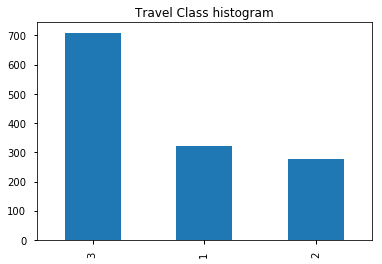

In [38]:
titanic['pclass'].value_counts().plot(kind='bar').set_title('Travel Class histogram')

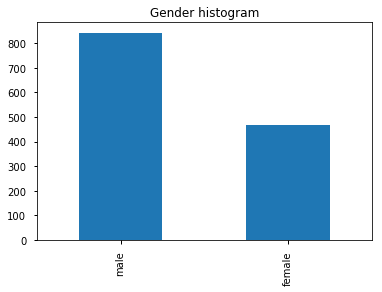

In [39]:
titanic['sex'].value_counts().plot(kind='bar').set_title('Gender histogram')

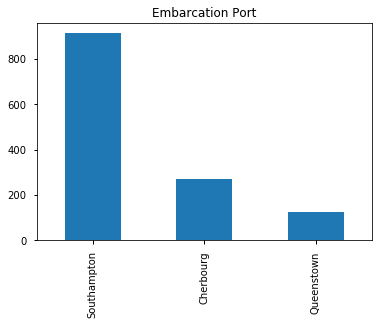

In [40]:
titanic['embarked'].value_counts().plot(kind='bar').set_title('Embarcation Port')

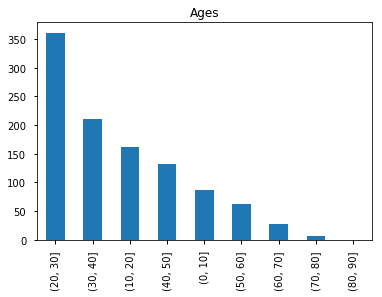

In [41]:
pd.cut(titanic.age, [0,10,20,30,40,50,60,70,80,90]).value_counts().plot(kind='bar').set_title('Ages')

***Question 3 : Now we plot the number of passenger depending on the cabine floor (represented by the letter at the beginning of the cabin***

In [42]:
titanic['cabin floor'] = titanic['cabin'].map(lambda x : x[0])

In [43]:
n_passenger = titanic['cabin floor'].value_counts().sum()
floor_repartition = titanic['cabin floor'].value_counts()
print("Floor repartion is :")
floor_repartition.map(lambda x: "{:06.3f}%".format(x/n_passenger *100))

Floor repartion is :


T    77.540%
C    07.181%
B    04.966%
D    03.514%
E    03.132%
A    01.681%
F    01.604%
G    00.382%
Name: cabin floor, dtype: object

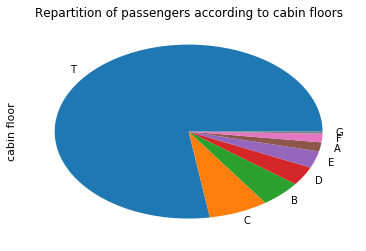

In [44]:
floor_repartition.plot(title='Repartition of passengers according to cabin floors',kind='pie')

**Question 4 : Now for each travel class, we calculate the proportion of the passengers that survived.**
The code is quite straightforward, we compute the number of survivor per class, then take the percentage per class. All the reste is simply cosmetic for it to look better

In [45]:
first_class = titanic[[c == 1 for c in titanic.pclass]]['survived'].value_counts()
n_1 = first_class.sum()
second_class = titanic[[c == 2 for c in titanic.pclass]]['survived'].value_counts()
n_2 = second_class.sum()
third_class = titanic[[c == 3 for c in titanic.pclass]]['survived'].value_counts()
n_3 = third_class.sum()

survived    61.920%
died        38.080%
Name: First class survivors, dtype: object


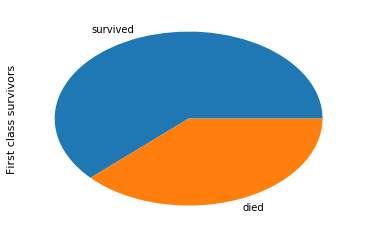

In [46]:
first_class_repartition = first_class.rename('First class survivors')
first_class_repartition.index = ['survived','died']
print(first_class_repartition.map(lambda x: "{:06.3f}%".format(x/n_1*100)))
first_class_repartition.plot(kind='pie')

survived    57.040%
died        42.960%
Name: Second class survivors, dtype: object


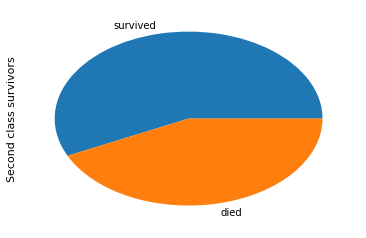

In [47]:
second_class_repartition = second_class.rename('Second class survivors')
second_class_repartition.index = ['survived','died']
print(second_class_repartition.map(lambda x: "{:06.3f}%".format(x/n_2*100)))
second_class_repartition.plot(kind='pie')

survived    74.471%
died        25.529%
Name: third class survivors, dtype: object


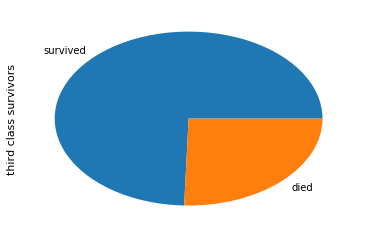

In [48]:
third_class_repartition = third_class.rename('third class survivors')
third_class_repartition.index = ['survived','died']
print(third_class_repartition.map(lambda x: "{:06.3f}%".format(x/n_3*100)))
third_class_repartition.plot(kind='pie')

**Question 5 : We now calculate the proportion of the passengers that survived by travel class and sex.**
We use seaborn ```factorplot``` to do that very simply?

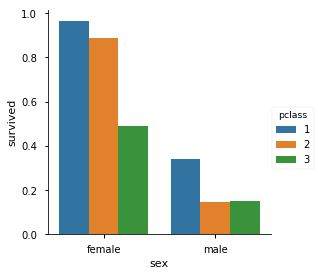

In [49]:
sns.factorplot(x='sex',y='survived',hue='pclass',kind='bar',data=titanic,ci=None)

** Question 6 : We want to create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. **
First we separate the ages into two equally populated categories that we will name 'young' and 'old' for the sake of simplicity. 

In [55]:
df = titanic[['pclass','sex','age','survived']]
df['age'] = pd.cut(titanic.age,2,labels=['young','old'])
df.head()

,pclass,sex,age,survived
0,1,female,young,1
1,1,male,young,1
2,1,female,young,0
3,1,male,young,0
4,1,female,young,0


Then we group those according to the the categories that interwst us, compute the sum (will sume the 1s corresponding to survivors and then compute the totals thanks to the ```count``` aggregation function

In [72]:
grouped = df.groupby(['pclass','sex','age']).agg({'survived':'sum'})
grouped['totals'] = df.groupby(['pclass','sex','age']).agg({'survived':'count'})
grouped

survived  totals
pclass sex    age                    
1      female old          48      50
              young        80      83
       male   old          21      79
              young        32      72
2      female old          13      16
              young        79      87
       male   old           2      34
              young        21     124
3      female old           4      12
              young        68     140
       male   old           2      36
              young        57     313

Now that we have the number of survivors as well as the count of the population of each group, we can very simply compute the proportion of survivors.


In [78]:
grouped['survived (%)'] = grouped['survived']/grouped['totals']*100
grouped[['survived (%)']].round(2)

survived (%)
pclass sex    age                
1      female old           96.00
              young         96.39
       male   old           26.58
              young         44.44
2      female old           81.25
              young         90.80
       male   old            5.88
              young         16.94
3      female old           33.33
              young         48.57
       male   old            5.56
              young         18.21